# Weight By Portfolio Strategy

Basic buy and hold that allows weighting by user specified weights, Equal, Sharpe Ratio, Annual Returns, Std Dev, Vola, or DS Vola.  

Rebalance is yearly, monthly, weekly, or daily.  Option to sell all shares of an investment is regime turns negative.

In [1]:
import datetime

import matplotlib.pyplot as plt
import pandas as pd
from talib.abstract import *

import pinkfish as pf
import strategy

# Format price data.
pd.options.display.float_format = '{:0.2f}'.format

%matplotlib inline

In [2]:
# Set size of inline plots.
'''note: rcParams can't be in same cell as import matplotlib
   or %matplotlib inline
   
   %matplotlib notebook: will lead to interactive plots embedded within
   the notebook, you can zoom and resize the figure
   
   %matplotlib inline: only draw static images in the notebook
'''
plt.rcParams["figure.figsize"] = (10, 7)

Some global data

In [3]:
# Symbol Lists.
SP500_Sectors = \
    {'XLB': None, 'XLE': None, 'XLF': None, 'XLI': None,
     'XLK': None, 'XLP': None, 'XLU': None, 'XLV': None, 'XLY': None}

Mixed_Asset_Classes = \
    {'IWB': None, 'SPY': None, 'VGK': None, 'IEV': None,
     'EWJ': None, 'EPP': None, 'IEF': None, 'SHY': None, 'GLD': None}
FANG_Stocks = \
    {'FB': None, 'AMZN': None, 'NFLX': None, 'GOOG': None}

Stocks_Bonds_Gold = \
    {'SPY': None, 'QQQ': None, 'TLT': None, 'GLD': None}

Stocks_Bonds = \
    {'SPY': 0.50, 'AGG': 0.50}

# Pick one of the above.
weights = Stocks_Bonds_Gold
symbols = list(weights)

capital = 100_000
start = datetime.datetime(*pf.ALPHA_BEGIN)
#start = datetime.datetime(*pf.SP500_BEGIN)
end = datetime.datetime.now()

In [4]:
weight_by_choices = ('equal', 'sharpe', 'ret', 'sd', 'vola', 'ds_vola')
rebalance_choices = ('yearly', 'monthly', 'weekly', 'daily')

options = {
    'use_adj'           : True,
    'use_cache'         : True,
    'margin'            : 1,
    'weights'           : weights,
    'weight_by'         : 'vola',
    'rebalance'         : 'monthly',
    'use_regime_filter' : False
}

Define Optimizations

In [5]:
# pick one
optimize_weight_by         = True
optimize_rebalance         = False
optimize_use_regime_filter = False


if optimize_weight_by:
    Xs = weight_by_choices

elif optimize_rebalance:
    Xs = rebalance_choices
    Xs = [str(X) for X in Xs]

elif optimize_use_regime_filter:
    Xs = (0, 1)
    Xs = [str(X) for X in Xs]

Run Strategy

In [6]:
strategies = pd.Series(dtype=object)
for X in Xs:
    print(X, end=" ")
    if optimize_weight_by:
        options['weight_by'] = X
    elif optimize_rebalance:
        options['rebalance'] = X
    elif optimize_use_regime_filter:
        options['use_regime_filter'] = False if X == '0' else True
    
    strategies[X] = strategy.Strategy(symbols, capital, start, end, options)
    strategies[X].run()

equal sharpe ret sd vola ds_vola 

Summarize results

In [7]:
metrics = ('annual_return_rate',
           'max_closed_out_drawdown',
           'annualized_return_over_max_drawdown',
           'best_month',
           'worst_month',
           'sharpe_ratio',
           'sortino_ratio',
           'monthly_std',
           'pct_time_in_market',
           'total_num_trades',
           'pct_profitable_trades',
           'avg_points')

df = pf.optimizer_summary(strategies, metrics)
df

,equal,sharpe,ret,sd,vola,ds_vola
annual_return_rate,11.20,11.01,9.73,10.72,11.45,10.23
max_closed_out_drawdown,-26.68,-20.32,-27.17,-20.66,-20.09,-19.96
annualized_return_over_max_drawdown,0.42,0.54,0.36,0.52,0.57,0.51
best_month,18.63,17.81,23.28,18.07,18.19,17.85
worst_month,-17.40,-16.97,-19.76,-14.20,-13.42,-12.72
sharpe_ratio,1.04,0.88,0.74,1.11,1.18,1.08
sortino_ratio,1.30,1.10,0.88,1.42,1.59,1.46
monthly_std,2.78,3.25,3.37,2.61,2.67,2.62
pct_time_in_market,100.00,100.00,100.00,100.00,100.00,100.00
total_num_trades,616.00,507.00,441.00,606.00,628.00,626.00


Bar graphs

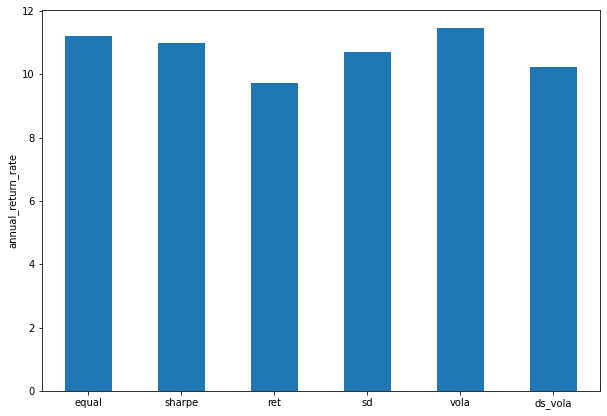

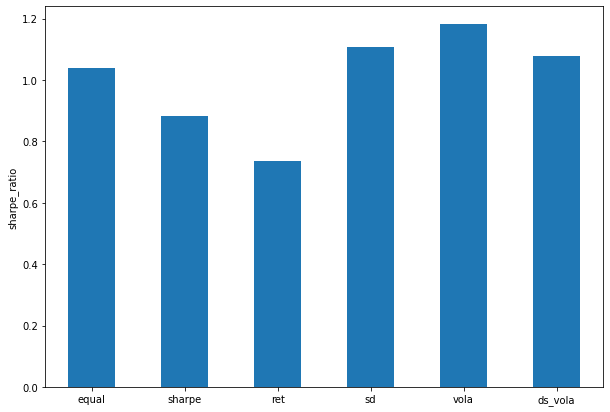

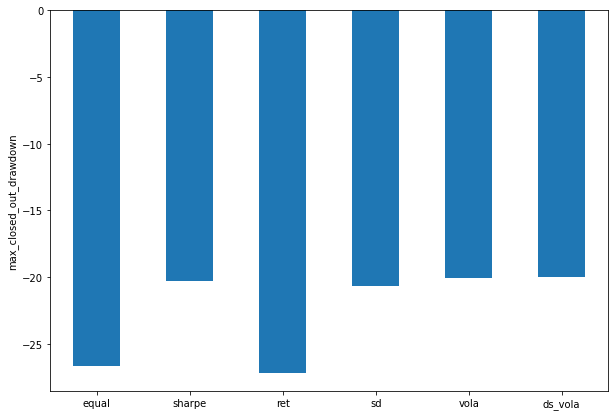

In [8]:
pf.optimizer_plot_bar_graph(df, 'annual_return_rate')
pf.optimizer_plot_bar_graph(df, 'sharpe_ratio')
pf.optimizer_plot_bar_graph(df, 'max_closed_out_drawdown')

Run Benchmark

In [9]:
s = strategies[Xs[0]]
benchmark = pf.Benchmark('SPY', capital, s.start, s.end, use_adj=True)
benchmark.run()

Equity curve

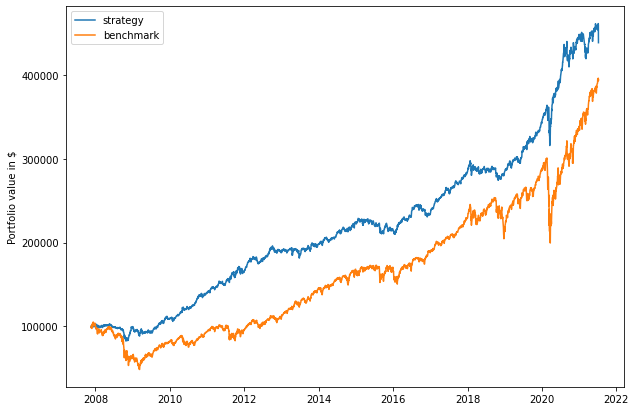

In [10]:
if   optimize_weight_by: Y = 'vola'
elif optimize_rebalance: Y = 'weekly'
elif optimize_use_regime_filter: Y = '0'

pf.plot_equity_curve(strategies[Y].dbal, benchmark=benchmark.dbal)

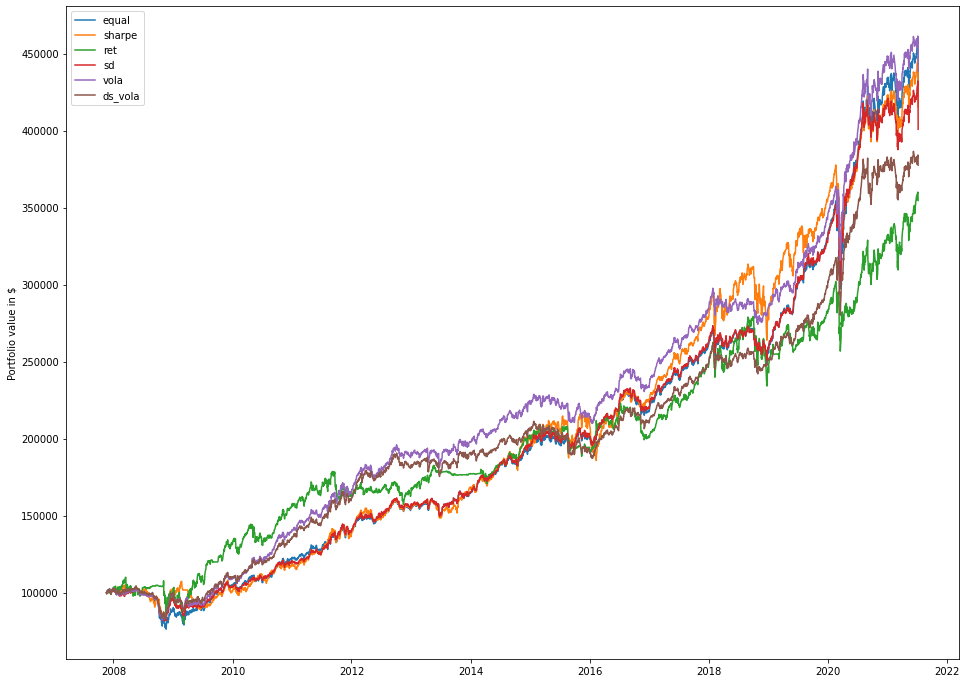

In [11]:
labels = []
for strategy in strategies:
    if optimize_weight_by:
        label = strategy.options['weight_by']
    elif optimize_rebalance:
        label = strategy.options['rebalance']
    elif optimize_use_regime_filter:
        label = strategy.options['use_regime_filter']
    labels.append(label)

pf.plot_equity_curves(strategies, labels)